In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

import pandas as pd
from src.location.location import Location, ETAB_NAMES
from src.features.hopital_features import HopitalFeatures
from src.features.meteorological_features import MeteorologicalFeatures
from pathlib import Path
from typing import List

In [2]:
start_date = "2019-01-01"
end_date = "2023-12-31"
DATA_DIR = Path('../data/features/')
EXOGENOUS = False

etab = ETAB_NAMES[0][1]

date_range = pd.date_range(start=start_date, end=end_date, freq='D').normalize()
df = pd.DataFrame({'date': date_range})
df.set_index('date', inplace=True)
loc = Location(etab)
features = [HopitalFeatures(name='hospitalfeatures', include_hnfc_moving=False, include_nb_hospit=False), 
            # MeteorologicalFeatures(name='meteorologicalfeatures')
            ]

for feature in features:
    df_temp = feature.fetch_data_function(location=loc, feature_dir=DATA_DIR / feature.name, start_date=start_date, stop_date=end_date)
    #df_temp.index.normalize()
    # print(df_temp)
    df = pd.merge(df, df_temp, how='left', left_index=True, right_index=True)


In [3]:
df

,nb_emmergencies_CH Beaune
date,
2019-01-01,54
2019-01-02,64
2019-01-03,54
2019-01-04,61
2019-01-05,60
...,...
2023-12-27,55
2023-12-28,57
2023-12-29,68


In [4]:
def categorize(df, column, bins=4, labels=None, drop=False):
    if labels == None and type(bins) == int: # or len(labels) != bins:
        labels = [f'{i+1}' for i in range(bins)]
    elif labels == None and type(bins) == list:
        labels = [f'{i+1}' for i in range(len(bins) - 1)]
    df[f'{column}_category'] = pd.qcut(df[column], q=bins, labels=labels)
    df[f'{column}_category'] = df[f'{column}_category'].astype('category')
    if drop:
        df.drop(columns=[column], inplace=True)
    return df

In [5]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Discretize with different numbers of quantiles
def calculate_mutual_info(df, target_column, n_quantiles):
    df[f'{target_column}_category'] = pd.qcut(df[target_column], q=n_quantiles, labels=False)
    mi = mutual_info_classif(df.drop(columns=[target_column, f'{target_column}_category']), df[f'{target_column}_category'])
    return mi.mean()

if len(features) > 1:
    best_score = (0, 0)
    # Example to try quantiles from 2 to 10
    for q in range(2, 11):
        mi_score = calculate_mutual_info(df, f'nb_emmergencies_{etab}', q)
        if mi_score > best_score[1]:
            best_score = (q, mi_score)
        print(f'Quantiles: {q}, Avg MI score: {mi_score:.4f}')
    print(f'Best quantiles: {best_score[0]}, Best MI score: {best_score[1]:.4f}')
else:
    best_score = (4, 0)

In [6]:
# bins = best_score[0]
#bins = [0, 0.2, 0.7, 1.0] # Define custom quantiles for 20%, 50%, and 30% bins
bins = [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0]

In [7]:
df = categorize(df, f'nb_emmergencies_{etab}', bins=bins)

In [8]:
df


,nb_emmergencies_CH Beaune,nb_emmergencies_CH Beaune_category
date,,
2019-01-01,54,3
2019-01-02,64,4
2019-01-03,54,3
2019-01-04,61,3
2019-01-05,60,3
...,...,...
2023-12-27,55,3
2023-12-28,57,3
2023-12-29,68,4


In [9]:
target_col = f'nb_emmergencies_{etab}'
category_col = f'{target_col}_category'


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



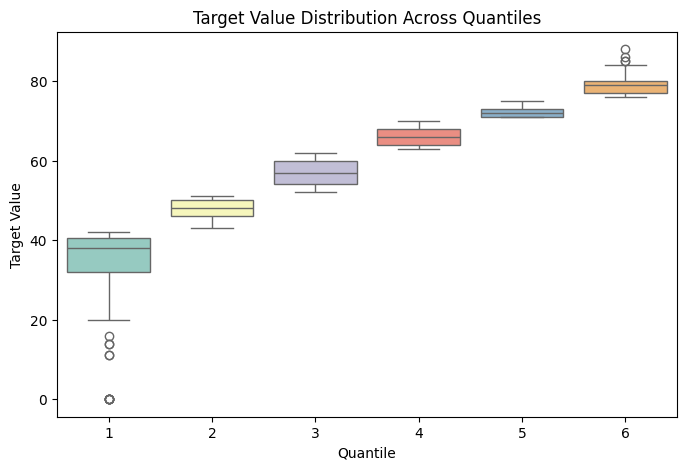

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x=category_col, y=target_col, data=df, palette='Set3')
plt.xlabel('Quantile')
plt.ylabel('Target Value')
plt.title('Target Value Distribution Across Quantiles')
plt.show()


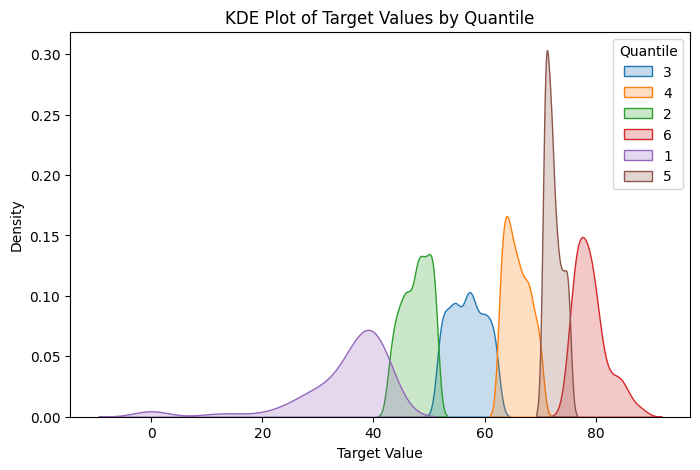

In [11]:
plt.figure(figsize=(8, 5))
for quantile in df[category_col].unique():
    sns.kdeplot(df[df[category_col] == quantile][target_col], label=f'{quantile}', fill=True)
plt.xlabel('Target Value')
plt.title('KDE Plot of Target Values by Quantile')
plt.legend(title='Quantile')
plt.show()


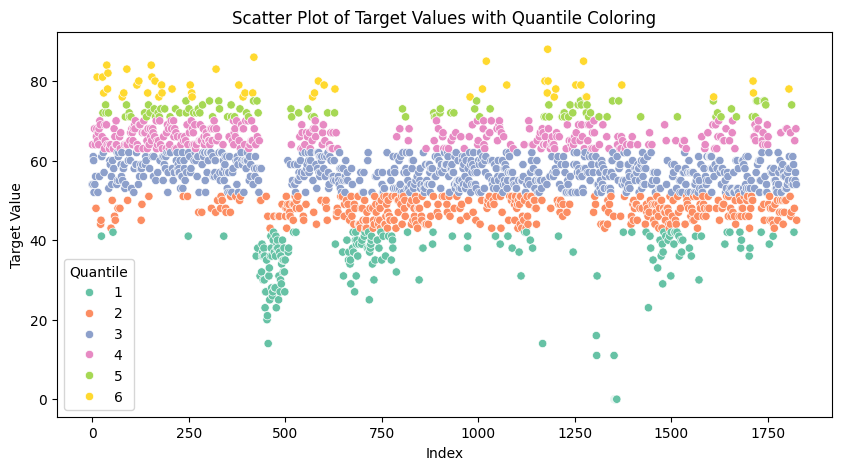

In [12]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=range(len(df)), y=target_col, hue=category_col, data=df, palette='Set2')
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.title('Scatter Plot of Target Values with Quantile Coloring')
plt.legend(title='Quantile')
plt.show()


In [ ]:
from src.datasets.base_tabular_dataset import BaseTabularDataset

data = BaseTabularDataset(df, target_col=target_col, category_col=category_col, exogenous=EXOGENOUS)